In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH





In [2]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def find_cached(df=None, hash=None):

    my_hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(my_hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + my_hash + ".csv").set_index("Unnamed: 0")

        print("Using cached df")

        return cachedDF, my_hash

    except:

        return False, my_hash
    

C:\Users\benma\AppData\Local\Temp/ipykernel_23772/857509499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
C:\Users\benma\AppData\Local\Temp/ipykernel_23772/857509499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()
100%|██████████| 39/39 [00:02<00:00, 19.28it/s]


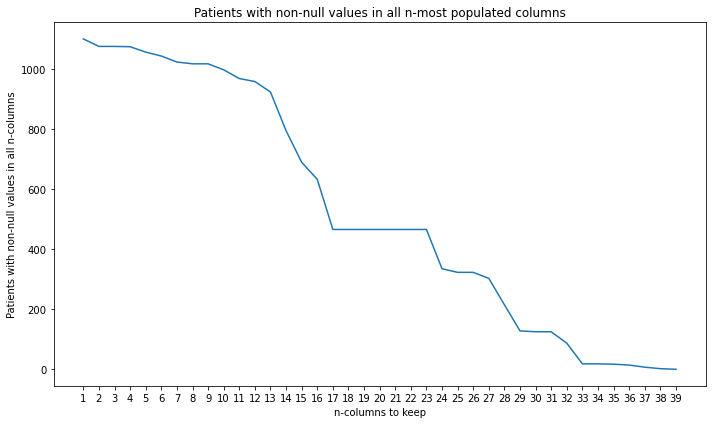

In [7]:
# Fixing 'arterial pH', 'ionized calcium' since they contain erroneous values.

mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()

patients = th.get_patients(mimicDF)

patientsKept, columnsExplored = th.count_null(patients)

patients = th.get_top_columns(patients, 12)

In [8]:
patients[0].topColumns

,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# tsfresh can't handle missing values



for patient in tqdm(patients):
    patient.cleanedDF = copy.copy(patient.topColumns)
    # patient.cleanedDF = patient.cleanedDF.apply(lambda x: x.interpolate(method='polynomial', order=2) if x.count() > 3 else np.NaN)
    for col in patient.cleanedDF:
        nonNullCount = patient.cleanedDF[col].count()

        if (nonNullCount >= 3):
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='polynomial', order=2)
        elif nonNullCount == 1:
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit=3)
        else:
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit_area='inside')

        patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit_area='outside')

        # patient.cleanedDF[col] = patient.cleanedDF[col].fillna(patient.cleanedDF[col].mean()).fillna(0)
    patient.cleanedDF["PatientID"] = patient.patientID
    # patient.cleanedDF = patient.cleanedDF.set_index(['PatientID'])
    
# formattedMimicDF = pd.DataFrame(columns=patients[0].data.columns)

# for patient in patients:
formattedMimicDF = pd.concat([patient.cleanedDF for patient in patients])

# formattedMimicDF = formattedMimicDF.set_index('PatientID')

display(formattedMimicDF)

100%|██████████| 959/959 [00:14<00:00, 65.46it/s]


,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI,PatientID
0,151.0,74.0,122.0,86.0,17.0,7.41,9.6,41.0,352.0,1644.439941,1.13,3609.760010,178177
1,151.0,74.0,122.0,86.0,17.0,7.41,9.6,41.0,352.0,1644.439941,1.13,3609.760010,178177
2,151.0,74.0,122.0,86.0,17.0,7.41,9.6,41.0,352.0,1644.439941,1.13,3609.760010,178177
3,151.0,74.0,122.0,86.0,17.0,7.41,9.6,41.0,352.0,1644.439941,1.13,3609.760010,178177
4,151.0,74.0,122.0,86.0,17.0,7.41,9.6,41.0,352.0,1644.439941,1.13,3609.760010,178177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,80.0,57.0,106.0,71.0,19.0,7.49,9.6,27.0,77.0,967.442017,1.11,1925.930054,159740
44,80.0,57.0,106.0,71.0,19.0,7.49,9.6,27.0,77.0,967.442017,1.11,1925.930054,159740
45,80.0,57.0,106.0,71.0,19.0,7.49,9.6,27.0,77.0,967.442017,1.11,1925.930054,159740
46,80.0,57.0,106.0,71.0,19.0,7.49,9.6,27.0,77.0,967.442017,1.11,1925.930054,159740


Display interpolation and fillna results here

In [10]:
formattedMimicDF.columns

Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2', 'Arterial PaO2', 'SVR', 'Ionized Calcium', 'SVRI',
       'PatientID'],
      dtype='object')

116747


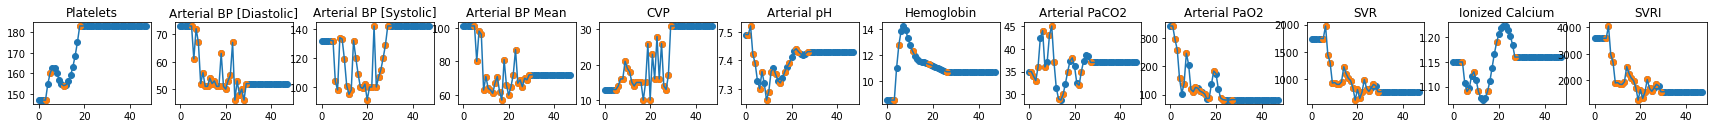

157708


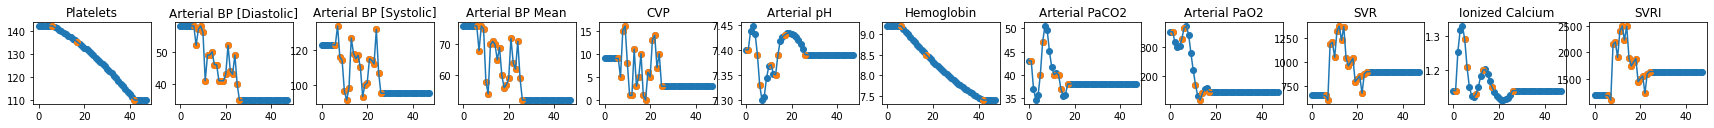

In [11]:
for patient in patients[5:7]:

    # display(clusteringPatients[i].interpolatedData.head())

    print(patient.patientID)


    step = 12

    columns = list(patient.cleanedDF.columns)[:-1]

    for idx in range(0, len(columns), step):


        fig = plt.figure(figsize = (30, 1.5))

        cols = columns[idx:idx+step]


        for k, col in enumerate(cols):

            plt.subplot(1, step, k+1)

            plt.plot(patient.cleanedDF.index, patient.cleanedDF[col])
            plt.scatter(patient.cleanedDF.index, patient.cleanedDF[col])
            plt.scatter(patient.cleanedDF.index, patient.data[col])
            plt.title(f"{col}")

        plt.show()

In [19]:
targetSeries = np.array([patient.mortality for patient in patients])

df = pd.DataFrame(data=targetSeries)

targetSeriesFormatted = df.set_index(formattedMimicDF["PatientID"].unique()).iloc[:,0].sort_index()

targetSeriesFormatted


Filtering important features


,CVP__quantile__q_0.3,CVP__quantile__q_0.4,CVP__quantile__q_0.2,CVP__minimum,CVP__quantile__q_0.1,CVP__median,CVP__mean,CVP__root_mean_square,CVP__quantile__q_0.6,CVP__c3__lag_3,CVP__c3__lag_2,CVP__c3__lag_1,CVP__variation_coefficient,CVP__quantile__q_0.7
100059,12.0,12.0,12.0,8.0,10.0,12.000000,12.812500,13.015215,12.0,2135.285714,2176.636364,2216.695652,0.178588,14.0
100298,11.0,11.0,10.0,5.0,6.7,11.000000,10.395833,10.631126,11.0,1161.119048,1155.227273,1167.173913,0.213960,11.0
100321,8.0,8.0,8.0,2.0,8.0,9.000000,10.291667,10.872366,11.0,1241.261905,1265.090909,1239.260870,0.340635,12.0
100336,18.0,18.0,18.0,9.0,18.0,21.226301,19.642885,19.974322,22.0,7674.692862,7793.128324,7985.852953,0.184475,22.0
100392,8.0,8.0,8.0,8.0,8.0,10.000000,11.404526,12.494598,10.0,1873.363283,1918.007183,1948.766060,0.447550,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199876,8.0,8.0,8.0,8.0,8.0,8.000000,9.833333,10.198039,9.0,1014.452381,1040.522727,1079.086957,0.274869,10.0
199877,12.0,12.0,10.0,7.0,9.7,13.000000,12.000000,12.134661,13.0,1766.261905,1757.022727,1770.217391,0.150231,13.0
199963,12.1,14.0,10.4,8.0,9.0,14.000000,13.611312,13.933927,14.0,2670.179148,2738.395113,2794.954067,0.219011,14.9
199993,13.0,13.0,13.0,12.0,13.0,13.000000,14.400796,14.562392,14.0,2974.187955,3003.944201,3045.578617,0.150228,15.0


In [32]:
## Checking if this DF already has cached time series features. Will save approx 15 mins if so.

# my_hash = hashlib.sha256(pd.util.hash_pandas_object(formattedMimicDF, index=True).values).hexdigest()

filtered_features, my_hash = find_cached(formattedMimicDF)


if filtered_features is False:

    extracted_features = extract_features(formattedMimicDF, column_id="PatientID", n_jobs=4)

    print("Imputing")
    impute(extracted_features)

    print("Filtering important features")
    filtered_features = select_features(extracted_features, formattedMimicDF)

    filtered_features.to_csv("./processingCache/" + my_hash + ".csv")

'26128f35758669a6e2001768a98df93bff7b0b8ac8fdf241d94641c49a83b901'

Using cached df


In [37]:
filtered_features = filtered_features.reindex(formattedMimicDF['PatientID'].unique())

filtered_features['PatientID'] = formattedMimicDF['PatientID'].unique()

filtered_features = filtered_features.set_index('PatientID')

display(filtered_features)

,CVP__quantile__q_0.3,CVP__quantile__q_0.4,CVP__quantile__q_0.2,CVP__minimum,CVP__quantile__q_0.1,CVP__median,CVP__mean,CVP__root_mean_square,CVP__quantile__q_0.6,CVP__c3__lag_3,CVP__c3__lag_2,CVP__c3__lag_1,CVP__variation_coefficient,CVP__quantile__q_0.7
PatientID,,,,,,,,,,,,,,
178177,5.0,6.0,5.000000,2.000000,2.304570,10.347350,10.481871,12.089007,17.0,1991.044181,2118.808407,2143.268993,0.574595,17.0
110594,10.0,10.0,9.000000,4.000000,7.700000,10.956433,11.818527,12.533960,12.2,1717.892085,1815.693849,2061.294823,0.353177,13.0
157699,10.0,10.0,10.000000,7.000000,9.700000,10.000000,11.541667,12.232130,10.0,1817.238095,1865.977273,2003.369565,0.351035,10.0
180230,11.0,12.8,11.000000,9.000000,10.000000,13.000000,12.979167,13.326821,13.0,2341.714286,2415.613636,2517.630435,0.232999,13.0
165898,11.0,11.8,9.000000,5.000000,7.000000,12.000000,12.204246,12.688859,12.2,1982.626610,2085.882896,2174.195900,0.284594,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,7.0,8.0,6.000000,-6.499985,3.054993,9.000000,8.038506,9.262189,10.0,639.696840,724.519262,786.160107,0.572389,11.0
116726,14.1,15.8,12.400000,1.000000,9.700000,17.000000,16.583333,17.498809,20.0,5406.214286,5626.772727,5840.652174,0.336833,20.9
169975,15.0,15.0,15.000000,14.000000,14.300000,15.000000,15.625000,15.720210,15.0,3944.888889,3937.200000,3942.681818,0.110562,15.0


In [38]:
for col in filtered_features.columns:
    print(col)

CVP__quantile__q_0.3
CVP__quantile__q_0.4
CVP__quantile__q_0.2
CVP__minimum
CVP__quantile__q_0.1
CVP__median
CVP__mean
CVP__root_mean_square
CVP__quantile__q_0.6
CVP__c3__lag_3
CVP__c3__lag_2
CVP__c3__lag_1
CVP__variation_coefficient
CVP__quantile__q_0.7


In [39]:
cat = Categorizer(filtered_features)

cat.agglomerative(n_clusters=3)

# categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

categories = {0: 'low', 1: 'medium', 2: 'high'}


mapped = cat.map_types(mapping=categories)['agglomerative']

display(mapped)

,CVP__quantile__q_0.3_high,CVP__quantile__q_0.3_low,CVP__quantile__q_0.3_medium,CVP__quantile__q_0.4_high,CVP__quantile__q_0.4_low,CVP__quantile__q_0.4_medium,CVP__quantile__q_0.2_high,CVP__quantile__q_0.2_low,CVP__quantile__q_0.2_medium,CVP__minimum_high,...,CVP__c3__lag_2_medium,CVP__c3__lag_1_high,CVP__c3__lag_1_low,CVP__c3__lag_1_medium,CVP__variation_coefficient_high,CVP__variation_coefficient_low,CVP__variation_coefficient_medium,CVP__quantile__q_0.7_high,CVP__quantile__q_0.7_low,CVP__quantile__q_0.7_medium
PatientID,,,,,,,,,,,,,,,,,,,,,
178177,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
110594,1,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
157699,1,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
180230,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
165898,1,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
116726,0,0,1,1,0,0,1,0,0,0,...,1,0,0,1,0,0,1,1,0,0
169975,0,0,1,1,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,1,0


In [26]:
mapped.to_csv("./categorisedData/metricExtractedData.csv")